# Object Detection Tests

Here, I do a survey of different open-vocabulary object detection methods.


In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ['HUGGINGFACE_HUB_CACHE'] = f'/scratch/{os.environ["USER"]}/huggingface_cache'

## Grounding DINO

This one seems to perform pretty well. However, it doesn't run on Rivanna for some reason?


In [ ]:
# # Grounding DINO
# import groundingdino.datasets.transforms as T
# from groundingdino.models import build_model
# from groundingdino.util.slconfig import SLConfig
# from groundingdino.util.utils import clean_state_dict
# from groundingdino.util.inference import predict, load_image
# import glob
# import sys

# from huggingface_hub import hf_hub_download

# import torch
# import PIL.Image
# from typing import Tuple
# import tqdm

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def load_model_hf(repo_id, filename, ckpt_config_filename, device):
#     cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

#     args = SLConfig.fromfile(cache_config_file) 
#     model = build_model(args)
#     args.device = device

#     cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
#     checkpoint = torch.load(cache_file, map_location=device)
#     log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
#     print("Model loaded from {} \n => {}".format(cache_file, log))
#     _ = model.eval()
#     return model

# transform = T.Compose([
#     # Selects a "random" size from the list [800,]
#     T.RandomResize([800], max_size=1333),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

# DetectionResult = Tuple[torch.Tensor, torch.Tensor, list]

# IMAGE_PATH = "droid_sample.png"
# TEXT_PROMPT = "Clear oil bottle".lower()
# BOX_TRESHOLD = 0.35
# TEXT_TRESHOLD = 0.25

# image_source, image = load_image(IMAGE_PATH)

# # Use this command for evaluate the Grounding DINO model
# # Or you can download the model by yourself
# ckpt_repo_id = "ShilongLiu/GroundingDINO"
# ckpt_filename = "groundingdino_swinb_cogcoor.pth"
# ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

# model = load_model_hf(ckpt_repo_id, ckpt_filename, ckpt_config_filename, device)
# model = model.to(device)

# raw_image = PIL.Image.open(IMAGE_PATH).convert("RGB")
# boxes, logits, phrases = predict(
#     model=model, 
#     image=image,
#     caption=TEXT_PROMPT, 
#     box_threshold=BOX_TRESHOLD, 
#     text_threshold=TEXT_TRESHOLD,
#     device=device,
# )

# annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

# plt.title("Grounding DINO test")
# plt.imshow(annotated_frame)
# plt.show()


## OWL-ViT

This one is available through HuggingFace. Hopefully it's less glitchy. It has a lot less parameters than Grounding DINO, though.


In [2]:
from transformers import pipeline
import numpy as np
from PIL import Image

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection", device="cuda")

image = Image.open("droid_sample.png").convert("RGB")


Detection duration: 2.20


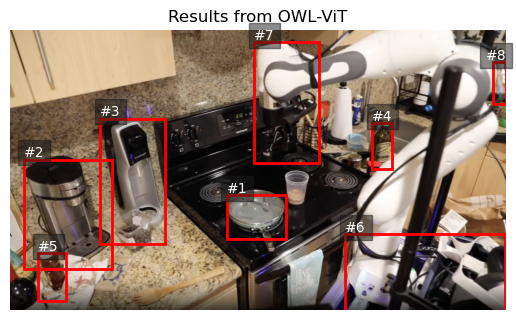

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.ops as ops
import torch
import time

start = time.time()
predictions = detector(
    image,
    candidate_labels=["clear oil bottle", "pan", "coffee machine"],
)
end = time.time()

print(f"Detection duration: {end - start:.2f}")

boxes_xy = []
for prediction in predictions:
    box = prediction['box']
    boxes_xy.append([box['xmin'], box['ymin'], box['xmax'], box['ymax']])
boxes_xy = torch.tensor(boxes_xy).float()

scores = torch.tensor([prediction['score'] for prediction in predictions])

keep = ops.nms(boxes_xy, scores, iou_threshold=0.3)
keep = set(int(x) for x in keep)

plt.clf()

plt.title("Results from OWL-ViT")
plt.imshow(image)

object_id_counter = 1
for i, prediction in enumerate(predictions):
    if i not in keep:
        continue
    
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    
    x1 = box['xmin']
    x2 = box['xmax']
    y1 = box['ymin']
    y2 = box['ymax']
    
    y1 *= (image.height/1024)
    y2 *= (image.height/1024)
    
    size = ((x2 - x1) * (y2 - y1)) / (image.width * image.height)
    
    if size > 0.25:
        continue
    
    plt.gca().add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor='r', linewidth=2))
    
    text_x = x1
    text_y = max(y1 - 20, 10)
    
    if (x1 / image.width) > 0.9:
        text_x = x2
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'left'
        
    plt.text(
        text_x,
        text_y,
        f"#{object_id_counter}",
        c='white',
        backgroundcolor=(0.1, 0.1, 0.1, 0.5),
        horizontalalignment=horizontalalignment
    )
    plt.axis('off')
    
    object_id_counter += 1
    
plt.show()
